# Install all kinds of requirements

In [2]:
!apt install libglfw3-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglfw3-dev is already the newest version (3.3.6-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [3]:
%pip install IPython
%pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install matplotlib
%pip install flax
%pip install einops

from IPython.display import HTML, clear_output
clear_output()

import functools
import os
from datetime import datetime

import jax
import matplotlib.pyplot as plt
from jax import numpy as jp

try:
    import brax
except ImportError:
    %pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

import flax
from brax import envs
from brax import geometry as braxgeo
from brax.io import html, json, model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

from einops import rearrange, repeat

## Double check GPU

In [4]:
!nvidia-smi

Sun May 14 07:37:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   42C    P8               27W / 420W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Train the agent on the base reward

In [5]:
env = envs.create(env_name="ant", backend="positional")

In [6]:
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

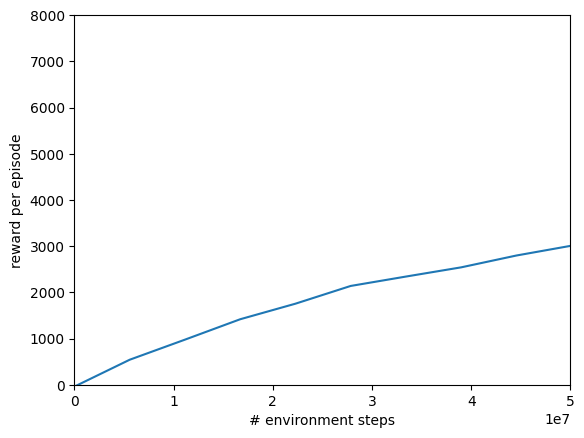

time to jit: 0:00:31.706494
time to train: 0:03:07.027973


In [7]:
max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)
    plt.xlim([0, 50_000_000])
    plt.ylim([min_y, max_y])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    plt.show()


make_inference_fn, params, _ = ppo.train(
    environment=env,
    progress_fn=progress,
    num_timesteps=50_000_000,
    num_evals=10,
    reward_scaling=10,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=5,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096,
    batch_size=2048,
    seed=1,
)


print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [8]:
model.save_params("/tmp/params", params)
params = model.load_params("/tmp/params")
inference_fn = make_inference_fn(params)

## Visualize

In [9]:
# @title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name="ant", backend="positional")

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

# Make the other reward functions

In [10]:
# @jax.jit
def flying_reward(state: envs.State, action: jax.Array) -> jax.Array:
    contact = braxgeo.contact(  # type: brax.base.Contact
        env.sys, state.pipeline_state.x  # type: ignore
    )

    num_contacts = contact.link_idx[0].shape[0]  # type: ignore

    return state.reward + num_contacts * -0.25

In [11]:
@jax.jit
def lazy_reward(state: envs.State, action: jax.Array) -> jax.Array:
    movement = jp.linalg.norm(action, axis=-1)

    return state.reward + movement * -0.5

In [12]:
@jax.jit
def steady_reward(state: envs.State, action: jax.Array) -> jax.Array:
    body_y_vel = state.pipeline_state.xd.vel[0]  # type: ignore

    return state.reward + body_y_vel**2 * -0.5

In [13]:
@jax.jit
def tall_reward(state: envs.State, action: jax.Array) -> jax.Array:
    z_height = state.pipeline_state.x.pos[0][2]  # type: ignore

    return state.reward + z_height * 0.25

## Add reward functions to reward_flavors array

In [14]:
reward_flavors = [flying_reward, lazy_reward, steady_reward, tall_reward]

# Collecting Rollouts to Rank

In [18]:
env = envs.create(env_name="ant", backend="positional")

jit_vec_env_reset = jax.jit(env.reset)
jit_vec_env_step = jax.jit(env.step)

rollouts = []
rng = jax.random.PRNGKey(seed=1)
states = jit_env_reset(rng=rng)

parallel_envs = 256
num_rollouts = 4096
trajectory_length = 1000

In [19]:
vmapped_reset = jax.vmap(jit_env_reset)
vmapped_step = jax.vmap(jit_env_step)
vmapped_inference_fn = jax.vmap(jit_inference_fn)

In [20]:
@jax.jit
def collect_rollout(
    rng: jax.Array
):
    rng, reset_rng = jax.random.split(rng)
    initial_state = jax.jit(env.reset)(rng=reset_rng)

    def scan_fn(state, rng):
        acts, _ = inference_fn(states.obs, rng)
        return jax.jit(env.step)(state, acts), (states, acts)

    rng, scan_rng = jax.random.split(rng)
    final_state, rollout = jax.lax.scan(
        f=scan_fn,
        init=initial_state,
        xs=jax.random.split(scan_rng, trajectory_length),
    )

    return rollout

In [24]:
@jax.jit
def scan_fn(_, rng):
    # jax.debug.print("collecting batch")

    env_rngs = jax.random.split(rng, parallel_envs)
    rollout_batch = jax.device_put(
        jax.vmap(collect_rollout)(env_rngs), jax.devices("cpu")[0]
    )

    # jax.debug.print("rollout_batch: {}", 3)

    return None, rollout_batch


rng, scan_rng = jax.random.split(rng)
_, rollout_batches = jax.lax.scan(
    f=scan_fn, init=None, xs=jax.random.split(scan_rng, num_rollouts // parallel_envs)
)

rollouts = jax.tree_map(
    lambda x: rearrange(x, "b e ... -> (b e) ..."), rollout_batches
)

del rollout_batches

2023-05-14 07:44:31.281216: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 562.50MiB (rounded to 589824000)requested by op 
2023-05-14 07:44:31.295089: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-05-14 07:44:31.296094: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2469] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 589824000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       128B
              constant allocation:     1.7KiB
        maybe_live_out allocation:   16.60GiB
     preallocated temp allocation:  136.96MiB
                 total allocation:   16.73GiB
Peak buffers:
	Buffer 1:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 589824000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       128B
              constant allocation:     1.7KiB
        maybe_live_out allocation:   16.60GiB
     preallocated temp allocation:  136.96MiB
                 total allocation:   16.73GiB
Peak buffers:
	Buffer 1:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 2:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 3:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 4:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 5:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 7:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 8:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 9:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 10:
		Size: 562.50MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.10"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,4]
		==========================

	Buffer 11:
		Size: 421.88MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.11"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,3]
		==========================

	Buffer 12:
		Size: 421.88MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.11"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,3]
		==========================

	Buffer 13:
		Size: 421.88MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.11"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,3]
		==========================

	Buffer 14:
		Size: 421.88MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.11"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,3]
		==========================

	Buffer 15:
		Size: 421.88MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_7796/1813236509.py" source_line=16 deduplicated_name="fusion.11"
		XLA Label: fusion
		Shape: f32[16,256,1000,9,3]
		==========================



In [ ]:
for reward_flavor in reward_flavors:
    
    def trajectory_reward(state: envs.State, action: jax.Array):
        jax.lax.reduce(jax.vmap(reward_flavor)(state, action), 0, lambda a, b: a + b)
    
    all_rewards = jax.vmap(trajectory_reward)(*all_rollouts)
    print(f"{reward_flavor.__name__}: {all_rewards.mean()}")